In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy as sp
import numpy as np
import os
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from itertools import combinations

%matplotlib inline

In [3]:
#optimal cutpoints

#find the closest point to (0,1) coordinate
def roc01(fpr, tpr):
    tl = [0,1]
    index = None
    opt = np.inf
    for i in range(len(fpr)):
        d = np.linalg.norm(np.array(tl) - np.array([fpr[i], tpr[i]]))
        if d < opt:
            opt = d
            index = i
    return fpr[index], tpr[index]

#Youden's index
def youden_index(fpr, tpr):
    sp = 1-fpr
    se = tpr
    index = None
    opt = -1
    for i in range(len(fpr)):
        pt = sp[i]+se[i]
        if pt > opt:
            opt = pt
            index = i
            
    return fpr[index], tpr[index]
    
#maximize sensitivity
def max_se(fpr, tpr, threshold=1e-4):
    sp = 1-fpr
    se = tpr
    index = None
    opt_se = -1
    opt_sp = -1
    for i in range(len(fpr)):
        if se[i] > opt_se:
            opt_se = se[i]
            opt_sp = sp[i]
            index = i
        elif abs(se[i]-opt_se) <= threshold:
            if sp[i] > opt_sp:
                opt_se = se[i]
                opt_sp = sp[i]
                index = i
    return fpr[index], tpr[index]

#maximize specificity
def max_sp(fpr, tpr, threshold=1e-4):
    sp = 1-fpr
    se = tpr
    index = None
    opt_se = -1
    opt_sp = -1
    for i in range(len(fpr)):
        if np.isclose(fpr[i],0.0):
            continue
        if sp[i] > opt_sp:
            opt_se = se[i]
            opt_sp = sp[i]
            index = i
        elif abs(sp[i]-opt_sp) <= threshold:
            if se[i] > opt_se:
                opt_se = se[i]
                opt_sp = sp[i]
                index = i
    return fpr[index], tpr[index]
                
## https://en.wikipedia.org/wiki/Diagnostic_odds_ratio
def max_dor(fpr, tpr):
    sp = 1-fpr
    se = tpr
    index = None
    opt_dor = -1
    for i in range(len(fpr)):
        dor = (se[i]/(1.0-se[i]))*(sp[i]/(1.0-sp[i]))
        if dor > opt_dor and not np.isinf(dor) and not np.isnan(dor):
            opt_dor = dor
            index = i
    return fpr[index], tpr[index]
    

In [4]:
n_classes = 5
n_clf = n_classes * (n_classes - 1) // 2
c_groups = [(t[1],t[0]) for t in list(combinations(list(range(0,n_classes)),2))]
plots_folder = os.path.join(os.getcwd(),'roc_plots')
if not os.path.exists(plots_folder):
    os.mkdir(plots_folder)

In [5]:
def real_data():
    data = pd.read_csv('processed.cleveland.data', names=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num'], header=None)
    invalidIndexes = []
    for row in data.itertuples():
        if '?' in row:
            invalidIndexes.append(row[0])
    new_data = data.drop(data.index[invalidIndexes])
    cols = list(new_data.columns)
    new_data[cols] = new_data[cols].astype('float32')
    return new_data


In [6]:
def synthetic_data(p, t):
    #mean1 = np.concatenate((np.ones(1)*-10,np.ones(12)))
    #mean2 = np.concatenate((np.ones(12),np.ones(1)*10))
    
    q0 = p*t
    q1 = p*(t-q0)
    q2 = p*(t-q0-q1)
    q3 = p*(t-q0-q1-q2)
    q4 = t-q0-q1-q2-q3
    
    q = [np.int(q0), np.int(q1), np.int(q2), np.int(q3), np.int(q4)]
    
    mean0 = np.ones(13)*1
    mean1 = np.ones(13)*1.5
    mean2 = np.ones(13)*1.7
    mean3 = np.ones(13)*0.5
    mean4 = np.ones(13)*1.65
    
    zeros = np.zeros((13,13))
    np.fill_diagonal(zeros, 1)
    
    v0 = np.random.rand(13,13)
    var0 = np.dot(v0,v0.T)*zeros
    v1 = np.random.rand(13,13)
    var1 = np.dot(v1,v1.T)*zeros
    v2 = np.random.rand(13,13)
    var2 = np.dot(v2,v2.T)*zeros
    v3 = np.random.rand(13,13)
    var3 = np.dot(v3,v3.T)*zeros
    v4 = np.random.rand(13,13)
    var4 = np.dot(v4,v4.T)*zeros
    
    
    g0 = np.random.multivariate_normal(mean0, np.eye(13), size=q[0])
    g1 = np.random.multivariate_normal(mean1, np.eye(13), size=q[1])
    g2 = np.random.multivariate_normal(mean2, np.eye(13), size=q[2])
    g3 = np.random.multivariate_normal(mean3, np.eye(13), size=q[3])
    g4 = np.random.multivariate_normal(mean4, np.eye(13), size=q[4])
    
    #g0 = np.random.multivariate_normal(mean0, var0, size=q[0])
    #g1 = np.random.multivariate_normal(mean1, var1, size=q[1])
    #g2 = np.random.multivariate_normal(mean2, var2, size=q[2])
    #g3 = np.random.multivariate_normal(mean3, var3, size=q[3])
    #g4 = np.random.multivariate_normal(mean4, var4, size=q[4])

    
    y0 = np.asarray([0]*q[0]).reshape(q[0],1)
    y1 = np.asarray([1]*q[1]).reshape(q[1],1)
    y2 = np.asarray([2]*q[2]).reshape(q[2],1)
    y3 = np.asarray([3]*q[3]).reshape(q[3],1)
    y4 = np.asarray([4]*q[4]).reshape(q[4],1)

    
    g0 = np.concatenate((g0,y0), axis=1)
    g1 = np.concatenate((g1,y1), axis=1)
    g2 = np.concatenate((g2,y2), axis=1)
    g3 = np.concatenate((g3,y3), axis=1)
    g4 = np.concatenate((g4,y4), axis=1)

    g = np.concatenate([g0,g1,g2,g3,g4], axis=0)

    d = pd.DataFrame(data=g, columns=['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num'])
    return d


In [11]:
def apply(times, percentage, quantity):
    scores_svm = []
    scores_youden = []
    scores_max_dor = []
    scores_d_one_votes = []
    scores_d_half_votes = []
    scores_d_zero_votes = []
    
    run_to_plot = np.random.randint(times)
    for t in tqdm(range(times)):
        data = synthetic_data(percentage, quantity)


        #data = real_data()

        ## split data into train and test
        cols = list(data.columns)
        cols.remove('num')
        target = data['num'].copy()
        input_data = data[cols].copy()
        #target_bin = label_binarize(target, classes=[0, 1, 2, 3, 4])
        #test removing healthy patients
        dTrain, dTest, targetTrain, targetTest = train_test_split(input_data, target, test_size=0.20, stratify=target)
        scaler = preprocessing.StandardScaler().fit(dTrain)
        dTrain = scaler.transform(dTrain)
        ovo = OneVsOneClassifier(SVC(kernel='linear', probability=True, class_weight='balanced', random_state=0), n_jobs=-1)
        ovo.fit(dTrain, targetTrain)

        dTest = scaler.transform(dTest)
        targetTestBin = label_binarize(targetTest, classes=[0, 1, 2, 3, 4])
        #probas = ovo.decision_function(dTest)
        #print(np.argmax(probas, axis=1))
        pred_2 = ovo.predict(dTest)
        #print(pred_2)
        #pred = np.argmax(probas, axis=1)
        #print(c_groups)
        votes = np.zeros(targetTestBin.shape)
        for i in range(n_clf):
            clf_ = ovo.estimators_[i]
            proba = clf_.decision_function(dTest)
            #print(proba)
            for j, p in enumerate(proba):
                #print(p)
                if p > 0:
                    votes[j, c_groups[i][0]] += 1
                else:
                    votes[j, c_groups[i][1]] += 1

        pred = np.argmax(votes, axis=1).astype(float)
        #print(votes)
        #print(pred)
        unique, counts = np.unique(targetTest, return_counts=True)
        #print(dict(zip(unique, counts)))
        cm = confusion_matrix(targetTest, pred_2)
        #print(cm)
        #acc = (cm.diagonal() / cm.sum(axis=1)).sum()/n_classes
        #print(acc)
        #test removing healthy patients


        #############################################
        clf_index = 0
        probas = []
        #Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        thresholds = dict()
        roc_auc = dict()
        cutpoints = dict()
        #for i in range(5):
        #test removing healthy patients
        for i in range(n_classes):
            for j in range(n_classes):
                if j > i:
                    clf = ovo.estimators_[clf_index]
                    #proba = clf.predict_proba(dTest)
                    proba = clf.decision_function(dTest)
                    probas.append(proba)
                    fpr[clf_index], tpr[clf_index], thresholds[clf_index] = roc_curve(abs(targetTestBin[:, i]-1), proba)
                    roc_auc[clf_index] = auc(fpr[clf_index], tpr[clf_index])
                    clf_index += 1

        for i in range(n_clf):
            opt_cutpoint3 = youden_index(fpr[i], tpr[i])
            opt_cutpoint4 = max_dor(fpr[i], tpr[i])
            c_index3 = np.where(fpr[i] == opt_cutpoint3[0])[0][0]
            c_index4 = np.where(fpr[i] == opt_cutpoint4[0])[0][0]
            if c_index3 == 0:
                c_index3 += 1
            if c_index4 == 0:
                c_index4 += 1

        
            cutpoints[i] = np.array([thresholds[i][c_index3], thresholds[i][c_index4]])
            #print(thresholds[i][c_index4])
            #print(thresholds[i][c_index3])
            if t == run_to_plot:
                fig, ax = plt.subplots()
                lw = 2
                ax.plot(fpr[i], tpr[i], color='darkorange',
                         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i], zorder=-1)
                ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', zorder=-1)
                plt.xlim([-0.05, 1.05])
                plt.ylim([-0.05, 1.05])
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title('Receiver operating characteristic for class ' + str(tuple(reversed(c_groups[i]))))
                ax.scatter(opt_cutpoint3[0], opt_cutpoint3[1], c='b', zorder=1, label='Youden', s=50)
                ax.scatter(opt_cutpoint4[0], opt_cutpoint4[1], c='r', zorder=1, label='Max Dor', s=50)
                ax.legend(loc="lower right")

                ax2 = plt.gca().twinx()
                ax2.plot(fpr[i], thresholds[i], color='r', lw=lw, linestyle='--', zorder=-1)
                ax2.set_ylabel('Threshold',color='r')
                ax2.set_ylim([thresholds[i][-1],thresholds[i][0]])
                ax2.set_xlim([-0.05, 1.05])
                plt.savefig(os.path.join(plots_folder, str(tuple(reversed(c_groups[i]))) + 
                                         str(percentage) + '_' + str(times) + '.png'))
                plt.close(fig)
                #plt.show()

        #######################################

        class_votes_c1 = np.zeros(targetTestBin.shape)
        class_votes_c2 = np.zeros(targetTestBin.shape)
        
        class_votes_d1 = np.zeros(targetTestBin.shape)
        class_votes_d2 = np.zeros(targetTestBin.shape)
        class_votes_d3 = np.zeros(targetTestBin.shape)
        
        for i in range(n_clf):
            clf = ovo.estimators_[i]
            proba = probas[i]
            for j, p in enumerate(proba):
                if p > cutpoints[i][0] or np.isclose(p,cutpoints[i][0]):
                    class_votes_c1[j, c_groups[i][0]] += 1
                else:
                    class_votes_c1[j, c_groups[i][1]] += 1


        for i in range(n_clf):
            clf = ovo.estimators_[i]
            proba = probas[i]
            for j, p in enumerate(proba):
                if p > cutpoints[i][1] or np.isclose(p,cutpoints[i][1]):
                    class_votes_c2[j, c_groups[i][0]] += 1
                else:
                    class_votes_c2[j, c_groups[i][1]] += 1
        
        for i in range(n_clf):
            clf = ovo.estimators_[i]
            proba = probas[i]
            #print(p, cutpoints[i].max(), cutpoints[i].min())
            for j, p in enumerate(proba):
                if p > cutpoints[i].max() or np.isclose(p, cutpoints[i].max()):
                    class_votes_d1[j, c_groups[i][0]] += 1
                    class_votes_d2[j, c_groups[i][0]] += 1
                    class_votes_d3[j, c_groups[i][0]] += 1
                elif p > cutpoints[i].min() and p < cutpoints[i].max():
                    class_votes_d1[j, c_groups[i][0]] += 1
                    class_votes_d1[j, c_groups[i][1]] += 1
                    class_votes_d2[j, c_groups[i][0]] += 0.5
                    class_votes_d2[j, c_groups[i][1]] += 0.5
                    class_votes_d3[j, c_groups[i][0]] += 0
                    class_votes_d3[j, c_groups[i][1]] += 0
                elif p < cutpoints[i].min():
                    class_votes_d1[j, c_groups[i][1]] += 1
                    class_votes_d2[j, c_groups[i][1]] += 1
                    class_votes_d3[j, c_groups[i][1]] += 1


        occurrences_c1 = np.asarray([np.where(t==t.max())[0] for t in class_votes_c1])
        occurrences_c2 = np.asarray([np.where(t==t.max())[0] for t in class_votes_c2])
        
        occurrences_d1 = np.asarray([np.where(t==t.max())[0] for t in class_votes_d1])
        occurrences_d2 = np.asarray([np.where(t==t.max())[0] for t in class_votes_d2])
        occurrences_d3 = np.asarray([np.where(t==t.max())[0] for t in class_votes_d3])
        
        new_preds_c1 = [p[-1] for p in occurrences_c1]
        new_preds_c2 = [p[-1] for p in occurrences_c2]
        
        new_preds_d1 = [p[-1] for p in occurrences_d1]
        new_preds_d2 = [p[-1] for p in occurrences_d2]
        new_preds_d3 = [p[-1] for p in occurrences_d3]
        #print(new_preds)
        #new_preds = np.argmax(class_votes, axis=1)
        #print(np.where(targetTest == 1)[0].shape[0])
        cm_c1 = confusion_matrix(targetTest, new_preds_c1)
        cm_c2 = confusion_matrix(targetTest, new_preds_c2)
        
        
        cm_d1 = confusion_matrix(targetTest, new_preds_d1)
        cm_d2 = confusion_matrix(targetTest, new_preds_d2)
        cm_d3 = confusion_matrix(targetTest, new_preds_d3)

        unique, counts = np.unique(targetTest, return_counts=True)
        #print(dict(zip(unique, counts)))
        #print(targetTest)
        #print('SVM: \n', cm)
        #print('Using c1(Youden): \n', cm_c1)
        #print('Using c2(Max DOR): \n', cm_c2)
        #print(cm_2.sum(axis=0))
        #acc_c1 = (cm_c1.diagonal() / cm_c1.sum(axis=1)).sum()/n_classes
        #acc_c2 = (cm_c2.diagonal() / cm_c2.sum(axis=1)).sum()/n_classes
        #print(acc_2)

        #print('Score 1: ', cm.diagonal().sum())
        #print('Score 2: ', cm_c1.diagonal().sum())
        #print('Score 3: ', cm_c2.diagonal().sum())
        
        scores_svm.append(cm.diagonal().sum())
        scores_youden.append(cm_c1.diagonal().sum())
        scores_max_dor.append(cm_c2.diagonal().sum())
        
        scores_d_one_votes.append(cm_d1.diagonal().sum())
        scores_d_half_votes.append(cm_d2.diagonal().sum())
        scores_d_zero_votes.append(cm_d3.diagonal().sum())
                          
        scores = [scores_svm, scores_youden, scores_max_dor, scores_d_one_votes, scores_d_half_votes, scores_d_zero_votes]
    return scores

In [12]:
percentages = np.arange(0.2, 0.85, 0.05)
times = 10
final_svm_score = []
final_youden_score = []
final_max_dor_score = []
final_scores_d_one_votes = []
final_scores_d_half_votes = []
final_scores_d_zero_votes = []

for p in percentages:
    scores = apply(10, p, 3000)
    final_svm_score.append(scores[0])
    final_youden_score.append(scores[1])
    final_max_dor_score.append(scores[2])
    
    final_scores_d_one_votes.append(scores[3])
    final_scores_d_half_votes.append(scores[4])
    final_scores_d_zero_votes.append(scores[5])


  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 10/10 [00:26<00:00,  2.44s/it]


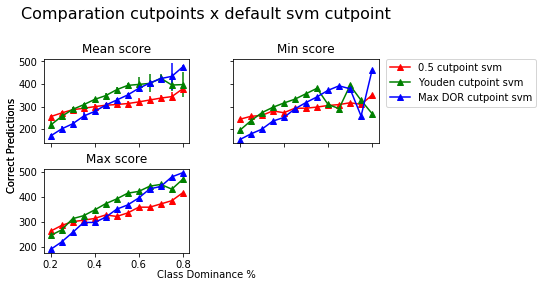

In [41]:
min_svm_score = np.asarray(final_svm_score).min(axis=1)
min_youden_score = np.asarray(final_youden_score).min(axis=1)
min_max_dor_score = np.asarray(final_max_dor_score).min(axis=1)

max_svm_score = np.asarray(final_svm_score).max(axis=1)
max_youden_score = np.asarray(final_youden_score).max(axis=1)
max_max_dor_score = np.asarray(final_max_dor_score).max(axis=1)

mean_svm_score = (np.mean(np.asarray(final_svm_score), axis=1))
mean_youden_score = (np.mean(np.asarray(final_youden_score), axis=1))
mean_max_dor_score = (np.mean(np.asarray(final_max_dor_score), axis=1))

std_svm_score = (np.std(np.asarray(final_svm_score), axis=1))
std_youden_score = (np.std(np.asarray(final_youden_score), axis=1))
std_max_dor_score = (np.std(np.asarray(final_max_dor_score), axis=1))

fig, ax = plt.subplots(2,2, sharex='col', sharey='row')
#ax.plot(percentages, mean_svm_score, color='r', label='0.5 cutpoint svm')
ax[0,0].errorbar(percentages, mean_svm_score, yerr=std_svm_score, color='r', label='0.5 cutpoint svm', fmt='-^')
ax[0,0].errorbar(percentages, mean_youden_score, yerr=std_youden_score, color='g', label='Youden cutpoint svm', fmt='-^')
ax[0,0].errorbar(percentages, mean_max_dor_score, yerr=std_max_dor_score, color='b', label='Max DOR cutpoint svm', fmt='-^')
#ax[0,0].legend(loc="lower right")
ax[0,0].set_title("Mean score")

ax[0,1].errorbar(percentages, min_svm_score, color='r', label='0.5 cutpoint svm', fmt='-^')
ax[0,1].errorbar(percentages, min_youden_score, color='g', label='Youden cutpoint svm', fmt='-^')
ax[0,1].errorbar(percentages, min_max_dor_score, color='b', label='Max DOR cutpoint svm', fmt='-^')
ax[0,1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax[0,1].set_title("Min score")


ax[1,0].errorbar(percentages, max_svm_score, color='r', label='0.5 cutpoint svm', fmt='-^')
ax[1,0].errorbar(percentages, max_youden_score, color='g', label='Youden cutpoint svm', fmt='-^')
ax[1,0].errorbar(percentages, max_max_dor_score, color='b', label='Max DOR cutpoint svm', fmt='-^')
#ax[1,0].legend(loc="lower right")
ax[1,0].set_title("Max score")

ax[1,1].axis('off')



fig.text(0.5, 0.04, 'Class Dominance %', ha='center')
fig.text(0.04, 0.5, 'Correct Predictions', va='center', rotation='vertical')
fig.text(0.04, 0.5, 'Correct Predictions', va='center', rotation='vertical')
plt.suptitle("Comparation cutpoints x default svm cutpoint", fontsize=16)
plt.setp([a.get_xticklabels() for a in ax[0, :]], visible=False)
plt.setp([a.get_yticklabels() for a in ax[:, 1]], visible=False)
fig.subplots_adjust(hspace=0.3, wspace=0.3, top=0.8)
plt.savefig(os.path.join(os.getcwd(), 'cutpoints_comparation_2.png'), bbox_inches='tight', pad_inches=0.5)
plt.show()
plt.close(fig)

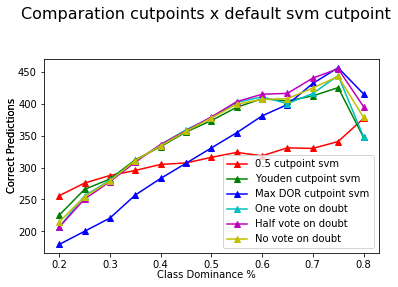

In [13]:
mean_svm_score = (np.mean(np.asarray(final_svm_score), axis=1))
mean_youden_score = (np.mean(np.asarray(final_youden_score), axis=1))
mean_max_dor_score = (np.mean(np.asarray(final_max_dor_score), axis=1))
mean_scores_d_one_votes = (np.mean(np.asarray(final_scores_d_one_votes), axis=1))
mean_scores_d_half_votes = (np.mean(np.asarray(final_scores_d_half_votes), axis=1))
mean_scores_d_zero_vote = (np.mean(np.asarray(final_scores_d_zero_votes), axis=1))


std_svm_score = (np.std(np.asarray(final_svm_score), axis=1))
std_youden_score = (np.std(np.asarray(final_youden_score), axis=1))
std_max_dor_score = (np.std(np.asarray(final_max_dor_score), axis=1))

fig, ax = plt.subplots()
#ax.plot(percentages, mean_svm_score, color='r', label='0.5 cutpoint svm')
ax.errorbar(percentages, mean_svm_score, color='r', label='0.5 cutpoint svm', fmt='-^')
ax.errorbar(percentages, mean_youden_score, color='g', label='Youden cutpoint svm', fmt='-^')
ax.errorbar(percentages, mean_max_dor_score, color='b', label='Max DOR cutpoint svm', fmt='-^')
ax.errorbar(percentages, mean_scores_d_one_votes, color='c', label='One vote on doubt', fmt='-^')
ax.errorbar(percentages, mean_scores_d_half_votes, color='m', label='Half vote on doubt', fmt='-^')
ax.errorbar(percentages, mean_scores_d_zero_vote, color='y', label='No vote on doubt', fmt='-^')
ax.legend(loc="lower right")



fig.text(0.5, 0.04, 'Class Dominance %', ha='center')
fig.text(0.04, 0.5, 'Correct Predictions', va='center', rotation='vertical')
fig.text(0.04, 0.5, 'Correct Predictions', va='center', rotation='vertical')
plt.suptitle("Comparation cutpoints x default svm cutpoint", fontsize=16)
fig.subplots_adjust(hspace=0.3, wspace=0.3, top=0.8)
plt.savefig(os.path.join(os.getcwd(), 'cutpoints_comparation_with_doubt.png'), bbox_inches='tight', pad_inches=0.5)
plt.show()
plt.close(fig)